In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [3]:
graph_builder = StateGraph(State)

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.0-pro")
llm.invoke("hi").content

c:\Users\sunny\langgraph-end-to-end\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Hello there! How may I assist you today?'

In [6]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [7]:
graph_builder.add_node("chatbot", chatbot)

In [9]:
graph_builder.add_edge(START, "chatbot")

In [10]:
graph_builder.add_edge("chatbot", END)

In [11]:
graph = graph_builder.compile()

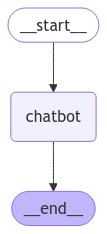

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [14]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello there! How can I assist you today?
Assistant: **Definition of Style**

Style refers to a distinctive manner or way of expressing oneself, whether in writing, speech, art, design, music, or fashion. It encompasses the choices and characteristics that define a particular aesthetic or approach.

**Elements of Style**

* **Content:** The subject matter, ideas, and information being communicated.
* **Form:** The structure and organization of the content, including syntax, grammar, rhythm, and composition.
* **Language:** The choice of words, tone, and register used to convey the content.
* **Design Elements:** In visual arts and design, style includes elements such as color, texture, pattern, and typography.
* **Personal Expression:** The unique qualities that reflect the artist, writer, or designer's personality and perspective.

**Types of Style**

* **Literary Style:** Includes genres such as fiction, non-fiction, poetry, and drama.
* **Artistic Style:** Encompasses move

In [15]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'}]

In [17]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [18]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [19]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

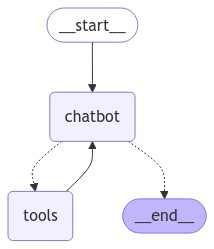

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [21]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I am sorry, I cannot fulfill this request. The available tools lack the desired functionality.


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised InternalServerError: 500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting.


User: What do you know about LangGraph?
Assistant: 
Assistant: [{"url": "https://towardsdatascience.com/from-basics-to-advanced-exploring-langgraph-e8c1cf4db787", "content": "LangGraph is a low-level framework that offers extensive customisation options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain, it's seamlessly integrated into its ecosystem, making it easy to leverage existing tools and components. However, there are areas where LangGrpah could be improved:"}, {"url": "https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141", "content": "LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its"}]
Assistant: LangGraph is a low-level framework that offers extensive customization options, allowing you to build precisely what you need. Since LangGraph is built on top of LangChain

In [22]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [24]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


In [25]:
graph = graph_builder.compile(checkpointer=memory)

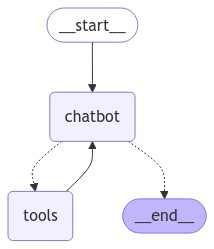

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
config = {"configurable": {"thread_id": "1"}}

In [28]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Nice to meet you Will! What can I help you with today?


In [29]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I do not have that capability, sorry.


In [30]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I cannot fulfill this request. I do not have the functionality to remember names.


In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [ ]:
StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='8c1ca919-c553-4ebf-95d4-b59a2d61e078'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?", additional_kwargs={}, response_metadata={'id': 'msg_01WTQebPhNwmMrmmWojJ9KXJ', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 405, 'output_tokens': 32}}, id='run-58587b77-8c82-41e6-8a90-d62c444a261d-0', usage_metadata={'input_tokens': 405, 'output_tokens': 32, 'total_tokens': 437}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='daba7df6-ad75-4d6b-8057-745881cea1ca'), AIMessage(content="Of course, I remember your name, Will. I always try to pay attention to important details that users share with me. Is there anything else you'd like to talk about or any questions you have? I'm here to help with a wide range of topics or tasks.", additional_kwargs={}, response_metadata={'id': 'msg_01E41KitY74HpENRgXx94vag', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 444, 'output_tokens': 58}}, id='run-ffeaae5c-4d2d-4ddb-bd59-5d5cbf2a5af8-0', usage_metadata={'input_tokens': 444, 'output_tokens': 58, 'total_tokens': 502})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef7d06e-93e0-6acc-8004-f2ac846575d2'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content="Of course, I remember your name, Will. I always try to pay attention to important details that users share with me. Is there anything else you'd like to talk about or any questions you have? I'm here to help with a wide range of topics or tasks.", additional_kwargs={}, response_metadata={'id': 'msg_01E41KitY74HpENRgXx94vag', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 444, 'output_tokens': 58}}, id='run-ffeaae5c-4d2d-4ddb-bd59-5d5cbf2a5af8-0', usage_metadata={'input_tokens': 444, 'output_tokens': 58, 'total_tokens': 502})]}}, 'step': 4, 'parents': {}}, created_at='2024-09-27T19:30:10.820758+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef7d06e-859f-6206-8003-e1bd3c264b8f'}}, tasks=())

In [31]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

NameError: name 'snapshot' is not defined